In [1]:
%matplotlib inline

In [2]:
import glob

import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.io import imread, imread_collection
from skimage.transform import resize
from skimage import exposure
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage.filters import unsharp_mask, threshold_sauvola
from skimage.morphology import dilation, erosion, area_closing, area_opening
from skimage.measure import label, regionprops

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import FunctionTransformer, label_binarize

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.svm import LinearSVC, SVC
from sklearn.multiclass import OneVsRestClassifier

from itertools import cycle

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, auc

# Recognition of handwritten digits on the DIDA dataset

## Table of content:
* [1. Introduction](#chapter1)
* [2. Dataset exploration](#chapter2)
    * [2.1 Loading the 10k single digit dataset](#section2_1)
    * [2.2 Analysing the aspect ratio and resolution of the dataset](#section2_2)
* [3. Image processing](#chapter3)
    * [3.1 Image resolution normalization](#section3_1)
    * [3.2 Feature extraction](#section3_2)
    * [3.3 Creating image processing pipeline](#section3_3)
* [4. Preparation for training](#chapter4)
    * [4.1 Label creation](#section4_1)
    * [4.2 Dimensionality reduction](#section4_2)
    * [4.3 Train-Test-Split](#section4_3)
    * [4.4 Model training](#section4_4)
    * [4.5 Model optimization](#section4_5)
    * [4.6 Storing the best estimator](#section4_6)
    * [4.7 Creating pipelines](#section4_7)
* [5. 12k digit string dataset exploration](#chapter5)
    * [5.1 Loading the 12k string dataset](#section5_1)
    * [5.2 Analysing the aspect ratio and resolution of the 12k string digit dataset](#section5_2)
* [6. Image processing](#chapter6)
    * [6.1 Image resolution normalization](#section6_1)
    * [6.2 Grayscale image conversion](#section6_2)
    * [6.3 Contrast sharpening](#section6_3)
    * [6.4 Image tresholding](#section6_4)
    * [6.5 Image morphology](#section6_5)
    * [6.6 Image segmentation](#section6_6)
        * [6.6.1 Image segments visualization](#sub_section6_6_1)
        * [6.6.2 Processing and ordering of the segments](#sub_section6_6_2)
    * [6.7 Experimenting with the assumption that the 10k single digit data set is a subset of the 12k string image dataset](#chapter6_7)
        * [6.7.1 Creating new SVM classifier without PCA](#sub_section6_7_1)
    * [6.8 Storing the best estimator](#section6_8)
    * [6.9 Cropping and classifying each segmented image](#section6_9)
    * [6.10 Loading digit labels from the 12k string image dataset](#section6_10)
* [7. Discussion](#chapter7)
* [8. Literature](#chapter8)

## Abstract

This notebook presents an approach to handwritten digit recognition on the DIDA dataset employing standard machine learning techniques. The support vector machine (SVM) classifier is utilized for its effectiveness in classification tasks. The Histogram of Oriented Gradients (HOG) descriptor is employed to capture distinctive patterns in the handwritten digits. Contrast enhancement, thresholding and morphology are used to prepare the string images for segmentation and classification. The proposed approach is a good starting point for future research.

## 1. Introduction <a class="anchor" id="chapter1"></a>

This notebook describes examination and process using standard machine learning algorithms on one of the largest colored historical handwritten digit datasets. DIDA dataset [1],[2] is collected from Swedish historical handwritten documents between 1800 and 1940. The main characteristics of this dataset are: 

Degradation: Because of the poor quality of the paper and inks used in 19th century, age of the documents, degradation and artifacts influence digits in DIDA dataset. Moreover, other artefacts in the document images are background variation, show-through, bleed-through, and smear.

Handwriting styles: Different handwriting styles can be observed in the dataset. The digits were written in copperplate, cursive, and Gothic styles by different priests using various types of ink, nib, and dip pen, which result in different appearances. Moreover in the dataset the same class of digits appear with different styles, shapes, digit size,  directions, digit order (in the string digit images) and image sizes.

The characteristics of this dataset make it very interesting for research in the field of OCR.

The DIDA dataset contains:
- single digit dataset 10K
- single digit dataset 70K
- single digit dataset 250K
- 12k digit string images and 12k digit string labels
- 30k digit string images without labels
- 58k digit string dataset without labels

## 2. Dataset exploration <a class="anchor" id="chapter2"></a>

### 2.1 Loading the 10k single digit dataset <a class="anchor" id="section2_1"></a>

First I will start analysis with the 10k single digit dataset. It is balanced dataset with 1000 samples per class. The digit from 0 to 9.

In [3]:
rootdir = 'C:/Users/adm/Desktop/DIDA/archive/10000/10000'
dir_list = []
for f in glob.glob(rootdir+'/*', recursive=True):
    dir_list.append(f+"/*jpg")

In [4]:
single_image_collection = imread_collection(dir_list)

For the purpose of visual inspection, it will be taken 10 samples (one per class) from the whole dataset at random.

In [5]:
np.random.seed(8)
random_image_samples = []
for random_image, en in enumerate(range(1, 11)):
    rand_im = np.random.randint((1000 * random_image), (1000 * en))
    random_image_samples.append(single_image_collection[rand_im])

The **sample_visualizer** function shows these 10 random images.

In [6]:
def sample_visualizer(img, dim = (2, 5), fsize = (10, 5), title = 'Number', cmap = None):
    rows, columns = dim
    im_index = 0

    fig, axes = plt.subplots(rows, columns, figsize = fsize)
    for row in range(0, rows):
        for col in range(0, columns):
            sub_image = img[im_index]
            if cmap != 'gray':
                axes[row, col].imshow(sub_image)
            else:
                axes[row, col].imshow(sub_image, cmap = cmap)
            axes[row, col].set_title('{}: {}'.format(title, im_index))
            im_index += 1
            
    plt.tight_layout()
    plt.show()

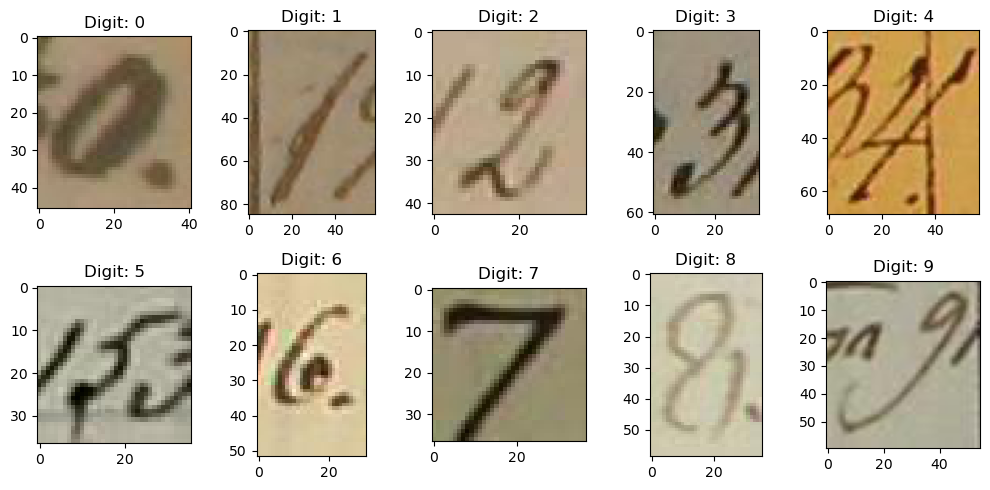

In [7]:
sample_visualizer(random_image_samples, title = 'Digit')

It can be seen that the digits have background that varies in color, artifacts in the image itself, paper degradation, and different image resolutions.

### 2.2 Analysing the aspect ratio and resolution of the dataset <a class="anchor" id="section2_2"></a>

In this step, all images from this dataset will be analyzed for resolution and aspect ratio. Because all images need to be normalized by resolution for subsequent image processing steps.

The **image_aspect_ratio_analizer** function analyze the aspect ratios of the dataset and shows the standard deviation, median value and mean value from this distribution.

In [8]:
def image_aspect_ratio_analyzer(img):
    x = []
    y = []
    for image in img:
        x.append(image.shape[1])
        y.append(image.shape[0])
    aspect_ratio = np.asarray(x) / np.asarray(y)
    plt.hist(aspect_ratio, bins = 'fd')
    plt.title('Aspect ratio histogram\n STD: {}, Median: {}, Mean: {}'\
              .format(round(aspect_ratio.std(ddof = 1), 5), \
                      round(np.median(aspect_ratio), 5),\
                      round(aspect_ratio.mean(), 5)))
    plt.xlabel('Aspect ratio x / y')
    plt.ylabel('Counts')
    plt.show()
    return np.asarray(x), np.asarray(y)

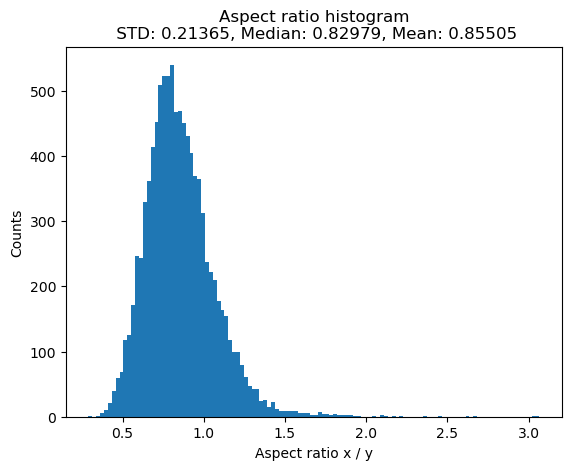

In [9]:
x_single_images, y_single_images = image_aspect_ratio_analyzer(single_image_collection)

The next number shows how many images from the data set has toller to square aspect ratios.

In [10]:
single_image_aspect_ratio = x_single_images / y_single_images
len(single_image_aspect_ratio[single_image_aspect_ratio <= 1])

8031

The next 2D histogram shows the pixel distribution in **'x' (width)** and **'y' (height)** for the images in the dataset.

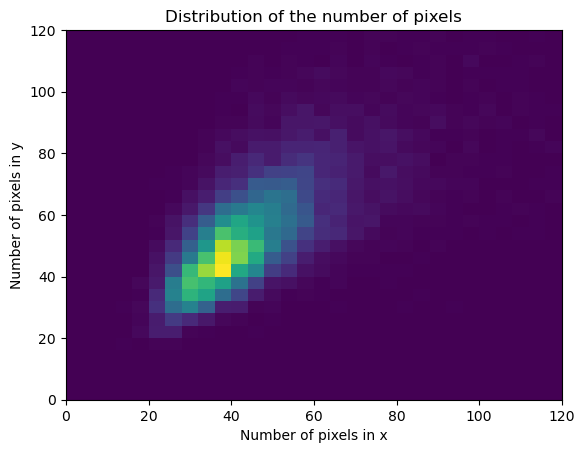

In [11]:
plt.hist2d(x_single_images, y_single_images, bins = 30, range = [(0, 120), (0, 120)])
plt.title('Distribution of the number of pixels')
plt.xlabel('Number of pixels in x')
plt.ylabel('Number of pixels in y')
plt.show()

Here it can be observed that the bigger part of the image dataset has portrait to square aspect ratio. It is about 80% of it. The Median value is about 0.83 which means that the most of the images are a bit toller that wider. The STD of 0.21 means that the variance in the aspect ratio distribution is not high. And respectively the most of the values are close to the mean value.
For simplicity each image will be resized in square shape with resolution of 32x32pix. Experiments with normalised images with higher resolution do not lead to significantly better performance.

## 3. Image processing <a class="anchor" id="chapter3"></a>

### 3.1 Image resolution normalization <a class="anchor" id="section3_1"></a>

At this step, all images must be normalized to the same resolution. The resolution should be 32x32pix.

In [12]:
def image_resizer(img, size = (32, 32)):
    resized_images = []
    for image in img:
        resized_image = resize(image, size)
        resized_images.append(resized_image)
    return np.asarray(resized_images)

In [13]:
resized_single_image_collection = image_resizer(single_image_collection)

In [14]:
resized_single_image_collection.shape

(10000, 32, 32, 3)

Now the 10k images are normalised to 32x32pix resolution and 3 channels (Red, Green and Blue).

Creating image resizing instance for the image processing pipeline.

In [15]:
resize_image_transformer = FunctionTransformer(func = image_resizer)

### 3.2 Feature extraction <a class="anchor" id="section3_2"></a>

Next step is a direct feature extraction approach using Histogram of Oriented Gradient (HOG).

The Histogram of Oriented Gradients (HOG) is a feature descriptor widely used in computer vision and image processing for object detection. The basic idea behind HOG is to capture the local gradient information in an image. The resulting HOG descriptor is a feature vector that captures the local gradient patterns in the image. It is particularly effective for detecting objects in images based on their shape and edge information [3], [4].

The next is the basic explanation on how does HOG work:
1. **Gradient computation:**:
    * Compute the gradient of the image to capture the intensity variations and edges. Typically, the gradients are computed using derivative filters, such as the Sobel operators. For a grayscale image $I$, the gradients $G_{x}$ and $G_{y}$ can be obtained using, for example, the Sobel operators:
    
    - For the gradients in $x$ direction: $$ G_{x} = I * \begin{pmatrix} -1 & 0 & 1\\ -2 & 0 & 2\\ -1 & 0 & 1\end{pmatrix} $$ 
   
    - For the gradients in $y$ direction: $$ G_{y} = I * \begin{pmatrix} -1 & -2 & -1\\ 0 & 0 & 0\\ 1 & 2 & 1\end{pmatrix} $$
    
2. **Gradient magnitude and orientation**:
    * Calculate the magnitude and orientation of the gradients at each pixel. The magnitude represents the strength of the gradient, and the orientation indicates the direction. Calculate the magnitude $M$ and orientation $\theta$ of the gradients of each pixel:
    
    - For the magnutute: $$ M = \sqrt{G^2_{x} + G^2_{y}}$$
    
    - For the orientation: $$ \theta = \arctan\left(\frac{G_{y}}{G_{x}}\right) $$
    
3. **Cell division**:
    * Divide the image into small cells. The gradient information within each cell is then used to represent the local structure.
    
4. **Histograms in cells**:
    * Create histograms of gradient orientations within each cell. The histogram bins represent different orientation ranges, and the histogram values $H_{cell}$ represent the distribution of gradient orientations within the cell.
    
5. **Block normalization**:
    * Group cells into larger blocks. Normalization is applied within each block to make the descriptor more robust to variations in illumination and contrast. This can be done using methods like L2 normalization.

    * L2 normalization, also known as Euclidean normalization. It is a process of scaling a vector by its Euclidean norm. Given vector $V$ with elements $\nu_{i}$, the L2 normalizaton is performed as folow:
    
    1. Compute the Euclidean norm $||V||_{2}$
    
        - $$ ||V||_{2} = \sqrt{\sum_{i=1}^{n}\nu_{i}^{2}} $$
    
    2. Normalize the vector $V$
        
        - $$ V_{normalized} =  \frac{V}{||V||_{2}} $$
        
    * The result is a vector $V_{normalized}$ with the same direction as the original vector $V$, but with a magnitude of 1.
    
6. **Descriptor concatenation**:
    * Concatenate the normalized block histograms to form the final HOG descriptor for the image.

An example of HOG descriptor. Short description of some hyperparameters:
- **orientation**: It is the number of histogram bins. In this case it is 9.
- **pixels_per_cell**: The image will be devided into cells with the specified size. In this case 8x8pix. Then the histogram of gradient orientation will be computed for each cell.
- **cells_per_block**: Grouping the cells into bigger blocks. Then normalisinig each block to account variations in illumination and contrast. In this case 2x2. Which mean 1 block contains 4 cells. 

Calculating the number of features from the HOG descriptor: For a 32x32pix image and cell size 8x8pix there are 16 cells with 9 values. Grouping these cells into 2x2 blocks it results in 4 cells with 9 values per cell. Which makes 36 values per block. When the block is shifted one cell in x and y direction to cover every possible 2x2 combinations of cells, it results in 3 shifts i x and 3 shift in y coordinates. The total number of features is: 36 features per block multiplied by 9 (3 shifts per direction) = 324 features.

Example of HOG descriptor visualization.

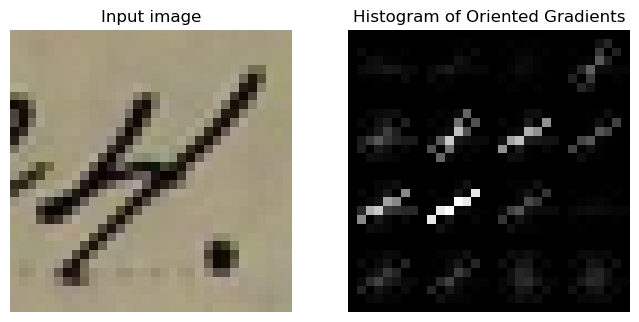

In [16]:
np.random.seed(8)
random_image_index = np.random.randint(0, 10000)

image = resized_single_image_collection[random_image_index]

fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, feature_vector = False, channel_axis=-1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

For the purpose of image recognition it will be used HOG descriptor with 6x6 pixels per block parameter. This will increase the number of features up to 576, but it is acceptable knowing that the original features are 1024. Furthermore using HOG discriptor increases the recognition capabilities of the model.

In [17]:
def hog_descriptor(img):
    hog_images = []
    for image in img:
        hog_image = hog(image, orientations=9, pixels_per_cell=(6, 6),
                        cells_per_block=(2, 2), visualize=False, channel_axis=-1)
        hog_images.append(hog_image)
    return np.asarray(hog_images)

In [18]:
hog_image_features = hog_descriptor(resized_single_image_collection)

In [19]:
hog_image_features.shape

(10000, 576)

Creating HOG feature extraction instance for the image processing pipeline.

In [20]:
hog_image_transformer = FunctionTransformer(func = hog_descriptor)

### 3.3 Creating image processing pipeline <a class="anchor" id="section3_3"></a>

In [21]:
image_processing_pipeline = Pipeline(steps = [
    ('image_resizeing', resize_image_transformer),
    ('hog_feature_extraction', hog_image_transformer)
])

In [22]:
#image_processing_pipeline.fit_transform(single_image_collection)

## 4. Preparation for training <a class="anchor" id="chapter4"></a>

### 4.1 Label creation <a class="anchor" id="section4_1"></a>

To be able to perform classification the labels should be created. Next step creates lebels for the 10k single digit dataset.

In [23]:
single_image_labels = np.empty(shape = (10000,))
for index, en in enumerate(range(1, 11)):
    val = np.ones(shape = (1000,)) * index
    single_image_labels[(1000 * index): (1000 * en)] = val

In [24]:
single_image_labels.shape

(10000,)

### 4.2 Dimensionality reduction <a class="anchor" id="section4_2"></a>

For this step Principal Component Analysis (PCA) is to be used over the whole dataset to keep 95% of the features that describe the image.

In [25]:
pca = PCA(0.95)

In [26]:
pca_image_features = pca.fit_transform(hog_image_features)

In [27]:
pca_image_features.shape

(10000, 189)

After dimensionality reduction we have 189 features out of 576 before.

### 4.3 Train-Test-Split <a class="anchor" id="section4_3"></a>

85% of the data (8.5k images) will be used for training and the remain 15%- for testing (1.5k images. 150 per class). Label stratification will be used to make sure we have equal samples from each class. The random state will be fixed as well in terms of reproducibility.

In [28]:
single_image_train, single_image_test, single_labels_train, single_labels_test = \
train_test_split(hog_image_features, single_image_labels, test_size = 0.15, stratify = single_image_labels, random_state = 8)

In [29]:
print(single_image_train.shape, 
      single_image_test.shape, 
      single_labels_train.shape, 
      single_labels_test.shape
     )

(8500, 576) (1500, 576) (8500,) (1500,)


For initial result evaluation the train set will be splited one more time in order to receive validation set. Validation set will be with 1000 samples - 100 per class. 

In [30]:
single_image_validation_train, single_image_validation_test, single_labels_validation_train, single_labels_validation_test = \
train_test_split(single_image_train, single_labels_train, test_size = 1000, stratify = single_labels_train, random_state = 8)

In [31]:
print(single_image_validation_train.shape, 
    single_image_validation_test.shape, 
    single_labels_validation_train.shape, 
    single_labels_validation_test.shape
     )

(7500, 576) (1000, 576) (7500,) (1000,)


### 4.4 Model training <a class="anchor" id="section4_4"></a>

For this classification task Linear Support Vector Machine classifier will be used. This classification algorithm has enough capacity to be able to cover the variety of the data. The main idea is to be a light, fast and explainable model. Initially the model will be trained with the default settings. Then it will be optimizied.

In [32]:
single_digit_classifier = LinearSVC(random_state = 8)

In [33]:
single_digit_classifier.fit(single_image_validation_train, single_labels_validation_train)

LinearSVC(random_state=8)

#### 4.4.1 Initial result evaluation <a class="anchor" id="section2_1"></a>

Check on how does the model perform on the training and testing data. It should have enough capacity to cover the training data well. This score gives just an idea about the capacity of the model. **Note: The accuracy metric is not suitable for multi-class evaluation.**

In [34]:
single_digit_classifier.score(single_image_validation_train, single_labels_validation_train)

0.9762666666666666

In [35]:
single_digit_classifier.score(single_image_validation_test, single_labels_validation_test)

0.907

In [36]:
single_digit_predicted = single_digit_classifier.predict(single_image_validation_test)

Showing precision, recall, f1-score metrics and confusion matrix for model performance evaluation.

In [37]:
def metrics(classifier, test_labels, predicted):
    print(
    f"Classification report for classifier {classifier}:\n"
    f"{classification_report(test_labels, predicted)}\n"
    )
    disp = ConfusionMatrixDisplay.from_predictions(test_labels, predicted)
    disp.figure_.suptitle("Confusion Matrix")
    plt.show() 

Classification report for classifier LinearSVC(random_state=8):
              precision    recall  f1-score   support

         0.0       0.96      0.89      0.92       100
         1.0       0.92      0.93      0.93       100
         2.0       0.94      0.91      0.92       100
         3.0       0.87      0.92      0.89       100
         4.0       0.87      0.96      0.91       100
         5.0       0.95      0.92      0.93       100
         6.0       0.94      0.93      0.93       100
         7.0       0.90      0.94      0.92       100
         8.0       0.84      0.82      0.83       100
         9.0       0.90      0.85      0.88       100

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000




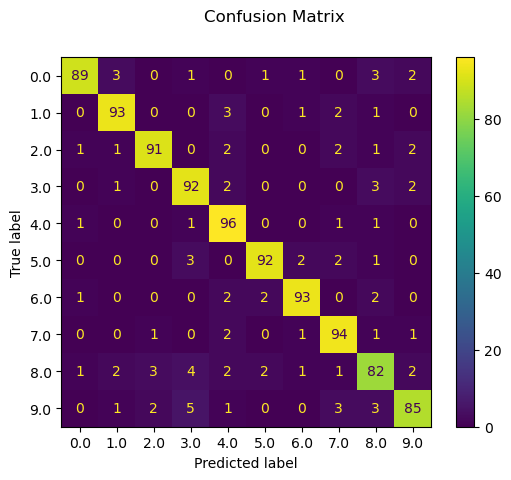

In [38]:
metrics(single_digit_classifier ,single_labels_validation_test, single_digit_predicted)

The metrics above describe a very robust performance of the model. Precision and recall metrics are very similar to each other for each class. That's why we have a very high F1-score metric.
When we look at the confusion matrix above it can be seen that the model has good consistent performance on the all classes. Only classes 8 and 9 perform slightly worse than the others, because the shape similarity between numbers 8 and 3 and slight similarity between 8, 2 and 0. Number 9 has same issue, since it has very close shape similarity to numbers 8 and 3. When we take into account the variety of the writing style of the numbers in the data set and the not optimized model, overall the initial results look optimistic.

In [39]:
def multiclass_roc_plot(X, y, cls_list, model, test_size):

    # Binarize the output
    y_bin = label_binarize(y, classes=cls_list)
    # Split the dataset into a training set and a test set
    X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size = test_size, stratify = y, random_state=8)

    # Learn to predict each class against the other
    classifier = OneVsRestClassifier(model)
    y_score = classifier.fit(X_train, y_train).decision_function(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    n_classes = y_bin.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curves for each class
    plt.figure(figsize=(12, 6))
    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = cycle(['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve for class {} (area = {:.2f})'.format(i, roc_auc[i]))

    # Plot micro-average ROC curve
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {:.2f})'.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    # Add random guessing line for reference
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')

    # Set plot details
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass Classification')
    plt.legend(loc='lower right')
    plt.show()

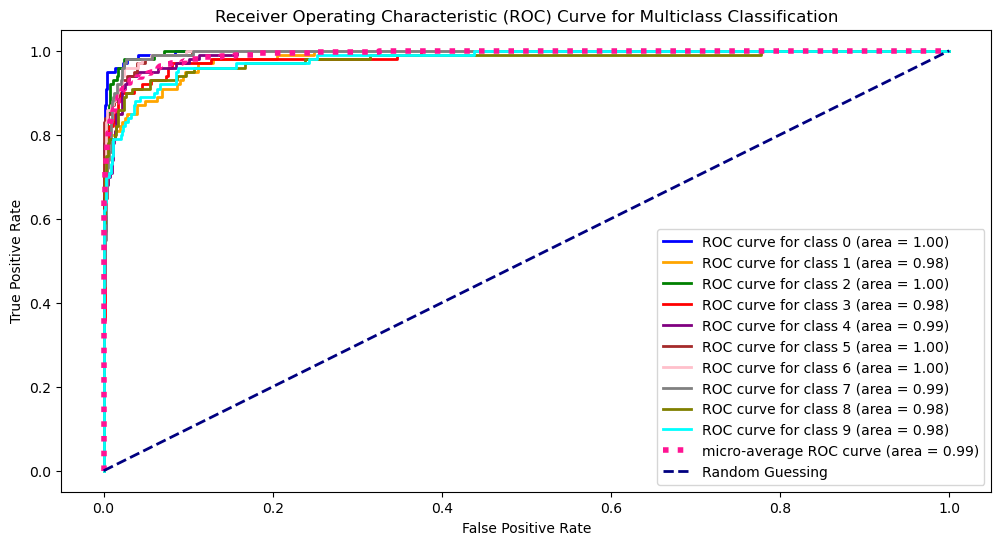

In [40]:
multiclass_roc_plot(single_image_validation_train, 
                    single_labels_validation_train, 
                    np.unique(single_labels_validation_train), 
                    single_digit_classifier,
                    test_size = 1000
                   )

The ROC curve above shows very good model performance.

### 4.5 Model optimization <a class="anchor" id="section4_5"></a>

GridSearchCV algorithm will be used for the model optimization.

These are the model hyperparameters that will be optimised. Penalty **l2** will be used, as a regularization function, because it works with both loss functions. The regularization parameter **C** will have 3 values for optimization. The **tol** paramter "tolerance for stopping criteria" refers to the parameter that determines when the optimization algorithm should stop. The default value is 1e-4. For this optimization one order up and down will be used. The **random_state** parameter will be set, because the default setting of **dual** is set to True.

In [41]:
param_grid_lin = {
    'penalty': ['l2'],
    'loss': ['hinge', 'squared_hinge'],
    'tol': [1e-3, 1e-4, 1e-5],
    'C': [ 0.01, 0.1, 1],
    'max_iter': [10000],
    'random_state': [8]
}

In [42]:
grid_search_single_digit_svm = GridSearchCV(LinearSVC(), param_grid_lin, cv = 5)

In [43]:
grid_search_single_digit_svm.fit(single_image_train, single_labels_train)

GridSearchCV(cv=5, estimator=LinearSVC(),
             param_grid={'C': [0.01, 0.1, 1],
                         'loss': ['hinge', 'squared_hinge'],
                         'max_iter': [10000], 'penalty': ['l2'],
                         'random_state': [8], 'tol': [0.001, 0.0001, 1e-05]})

In [44]:
print(grid_search_single_digit_svm.best_params_)

{'C': 0.1, 'loss': 'squared_hinge', 'max_iter': 10000, 'penalty': 'l2', 'random_state': 8, 'tol': 0.001}


In [45]:
grid_search_single_digit_predicted = grid_search_single_digit_svm.best_estimator_.predict(single_image_test)

In [46]:
#grid_search_single_digit_svm.cv_results_

Classification report for classifier LinearSVC(C=0.1, max_iter=10000, random_state=8, tol=0.001):
              precision    recall  f1-score   support

         0.0       0.92      0.93      0.92       150
         1.0       0.88      0.87      0.88       150
         2.0       0.91      0.91      0.91       150
         3.0       0.85      0.86      0.86       150
         4.0       0.90      0.89      0.90       150
         5.0       0.91      0.95      0.93       150
         6.0       0.91      0.93      0.92       150
         7.0       0.91      0.91      0.91       150
         8.0       0.91      0.90      0.90       150
         9.0       0.89      0.84      0.87       150

    accuracy                           0.90      1500
   macro avg       0.90      0.90      0.90      1500
weighted avg       0.90      0.90      0.90      1500




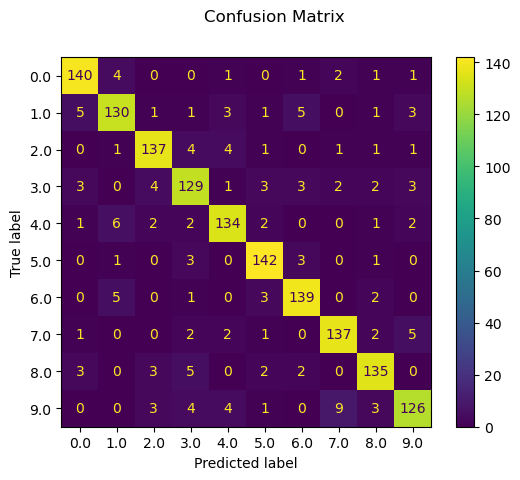

In [47]:
metrics(grid_search_single_digit_svm.best_estimator_ ,single_labels_test, grid_search_single_digit_predicted)

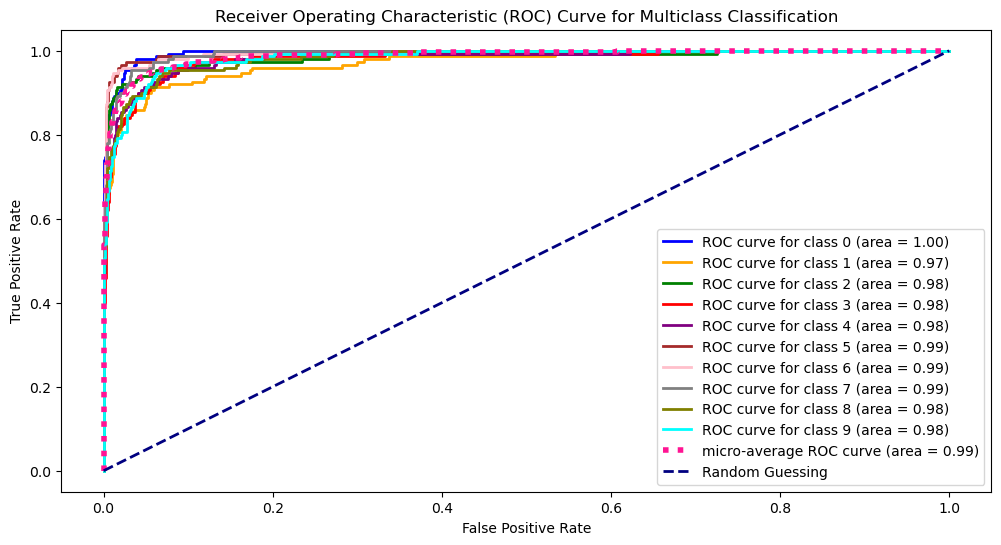

In [48]:
multiclass_roc_plot(pca_image_features, single_image_labels, 
                    np.unique(single_image_labels), 
                    grid_search_single_digit_svm.best_estimator_, 
                    test_size = 0.15
                   )

### 4.6 Storing the best estimator <a class="anchor" id="section4_6"></a>

joblib is used to store the model, because it is more efficient that the pickle on objects that carry large numpy arrays.

In [49]:
joblib.dump(grid_search_single_digit_svm.best_estimator_, 'single_digit_hog_pca_model')

['single_digit_hog_pca_model']

### 4.7 Creating pipelines <a class="anchor" id="section4_7"></a>

Model training pipeline.

In [50]:
#model_training_pipeline = Pipeline(steps = [
#    ('pca', PCA(n_components=50)),
#    ('LinearSVC', LinearSVC())
#])

In [51]:
#param_grid = {
#    'LinearSVC__penalty': ['l2'],
#    'LinearSVC__loss': ['hinge', 'squared_hinge'],
#    'LinearSVC__tol': [1e-3, 1e-4, 1e-5],
#    'LinearSVC__C': [0.01, 0.1, 1],
#    'LinearSVC__max_iter': [10000],
#    'pca__n_components': [50, 100, 150, 200]
#}

In [52]:
#est = GridSearchCV(model_training_pipeline, param_grid)

In [53]:
#est.fit(single_image_train, single_labels_train)

In [54]:
#print(est.best_estimator_, est.best_score_)

In [55]:
#est.best_estimator_

In [56]:
#est.predict(single_image_test)

In [57]:
#est.get_params()

In [58]:
#model_training_pipeline.fit(single_image_train, single_labels_train)

In [59]:
#model_training_pipeline.predict(single_image_test)

## 5. 12k digit string dataset exploration <a class="anchor" id="chapter5"></a>

### 5.1 Loading the 12k string dataset <a class="anchor" id="section5_1"></a>

In [60]:
str_rootdir = 'C:/Users/adm/Desktop/DIDA/archive/DIDA_12000_String_Digit_Images/DIDA_1/*.jpg'
str_image_collection = imread_collection(str_rootdir)

Create a function that takes a specified number of random samples from a set of specified length. Take 12 random samples from the dataset for visual analisys.

In [61]:
def random_sample_picker(elements, elem_range = (0, 1), samples = 1):
    np.random.seed(8)
    random_samples = []
    for i in np.random.randint(elem_range[0], (elem_range[1] + 1), size = samples):
        random_samples.append(elements[i])
    return random_samples

In [62]:
random_str_samples = random_sample_picker(str_image_collection, elem_range = (0, 12000), samples = 12)

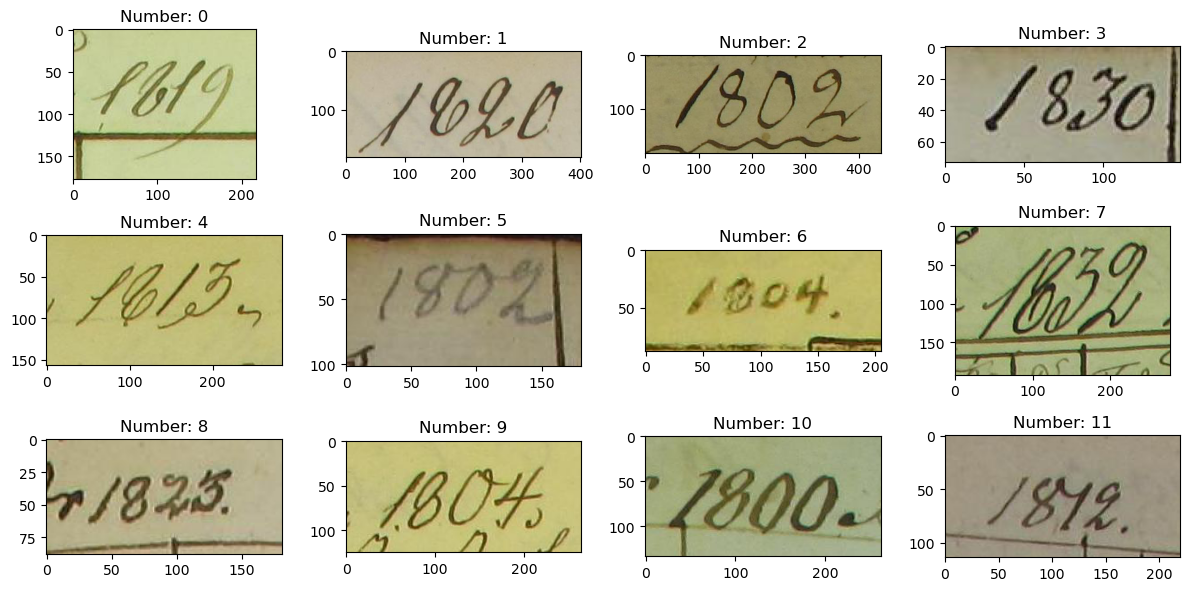

In [63]:
sample_visualizer(random_str_samples, fsize = (12, 6), dim = (3, 4), title = 'Number')

It is not a surprise that the situation is the same as the 10k single digit dataset. It can be seen that the digits have background that varies in color, artifacts in the image itself, paper degradation, and different image resolutions. **The main assumption here is that the single digit datasets are subsets of the string image dataset.**

### 5.2 Analysing the aspect ratio and resolution of the 12k string digit dataset <a class="anchor" id="section5_2"></a>

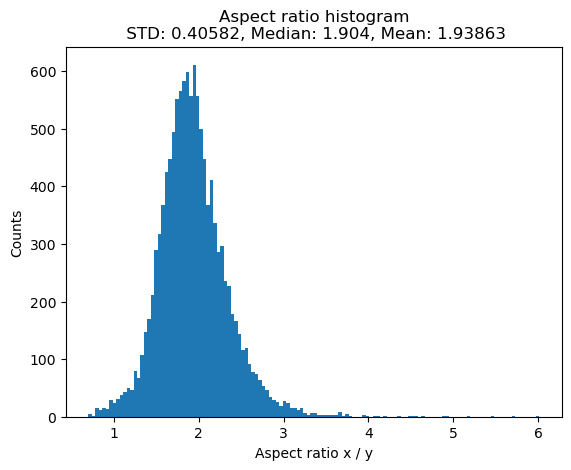

In [65]:
x_str_images, y_str_images = image_aspect_ratio_analyzer(str_image_collection)

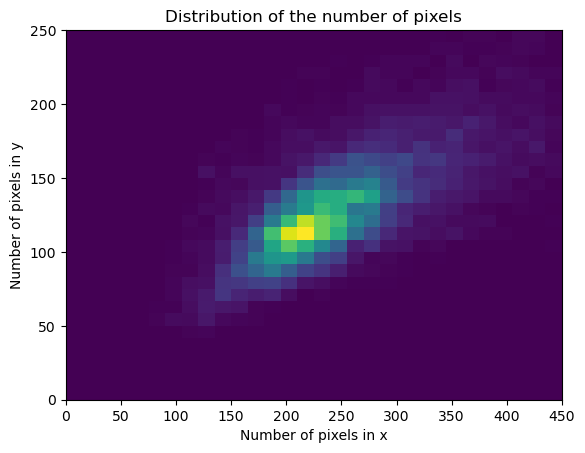

In [66]:
plt.hist2d(x_str_images, y_str_images, bins = 30, range = [(0, 450), (0, 250)])
plt.title('Distribution of the number of pixels')
plt.xlabel('Number of pixels in x')
plt.ylabel('Number of pixels in y')
plt.show()

The bigger part of the images have rectangular landscape format with aspect ratio very close to 2:1 as per the aspect ratio histogram. In order to work with these images, resolution normalization needs to be performed on them. Based on the 2D histogram which represents the distribution of the pixels in x and y coordinates, all images will be resized to 128x265 pix.

## 6. Image processing <a class="anchor" id="chapter6"></a>

### 6.1 Image resolution normalization <a class="anchor" id="section6_1"></a>

At this step, all images must be normalized to the same resolution. The resolution will be 128x256pix.

In [67]:
resized_str_image_collection = image_resizer(str_image_collection, size = (128, 256))

In [68]:
resized_str_image_collection.shape

(12000, 128, 256, 3)

### 6.2 Grayscale image conversion <a class="anchor" id="section6_2"></a>

**rbg2gray** function from skimage will be used for this task. The result after the conversion will in the range be between 0 and 1.

In [69]:
def gray_image(img):
    gray_images = []
    for image in img:
        gray_images.append(rgb2gray(image))
    gray_images_arr = np.asarray(gray_images)
    return gray_images_arr

In [70]:
gray_str_images = gray_image(resized_str_image_collection)

In [71]:
gray_str_images.shape

(12000, 128, 256)

Visualization of some random gray images

In [72]:
random_gray_str_samples = random_sample_picker(gray_str_images, elem_range = (0, 12000), samples = 6)

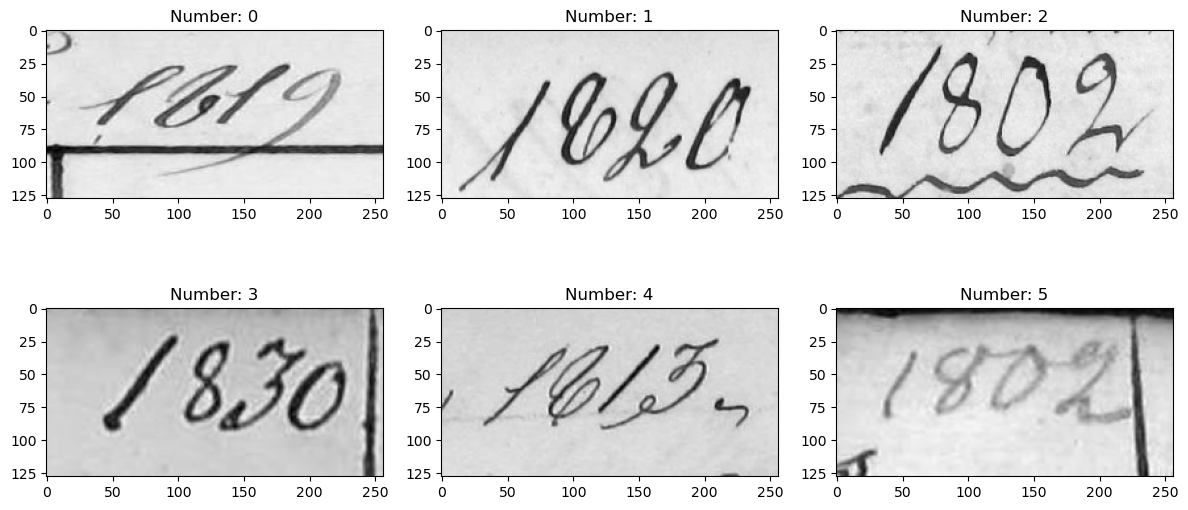

In [73]:
sample_visualizer(random_gray_str_samples, fsize = (12, 6), dim = (2, 3), title = 'Number', cmap = 'gray')

### 6.3 Contrast sharpening <a class="anchor" id="section6_3"></a>

At this step all images will be sharpened using **unsharp_mask** form skimage.
Unsharp masking is a linear image processing technique used for image sharpening by enhancing edges and details. The algorithm creates blurred version of the original image using smoothing filter, often Gaussian blurr. This procedure reduces high-frequency components. Then it creates mask by substracting the blurred image from the original one. The mask is emphasizing edges and fine details. The final step is amplification. The algorithms adds mask to the last result to enhance the intesity and the detail in the image [5], [6].

In [74]:
def sharp_image(img):
    sharp_images = []
    for image in img:
        sharp_image = unsharp_mask(image, radius=10, amount=1)
        sharp_images.append(sharp_image)
    shart_images_arr = np.asarray(sharp_images)
    return shart_images_arr

In [75]:
sharp_str_images = sharp_image(gray_str_images)

In [76]:
sharp_str_images.shape

(12000, 128, 256)

In [77]:
random_sharp_str_samples = random_sample_picker(sharp_str_images, elem_range = (0, 12000), samples = 6)

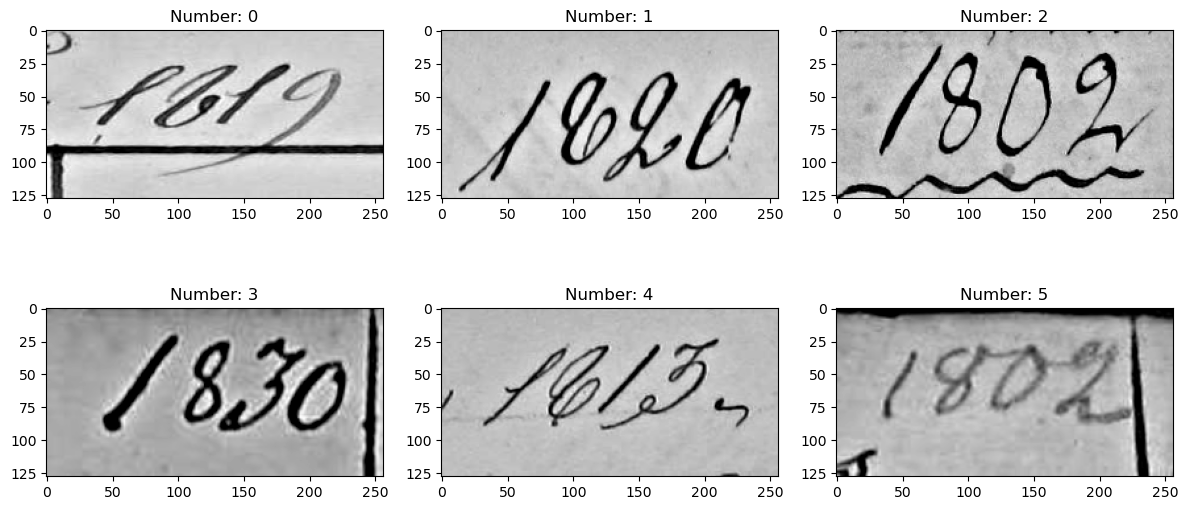

In [78]:
sample_visualizer(random_sharp_str_samples, fsize = (12, 6), dim = (2, 3), title = 'Number', cmap = 'gray')

### 6.4 Image tresholding <a class="anchor" id="section6_4"></a>

Sauvola thresholding is an adaptive thresholding technique used for binarization of images. It is particularly effective for documents with varying illumination conditions. Algorithm divide the image into non-overlapping blocks. For each block, it computes the local mean value of pixel intensities within that block. Then it performs local standard deviation computation of each pixel intesities for each block. Next the algorithm performs adaptive treshold. Last step is binarization- it compares each pixel intesity to the assessed adaptive treshold [7].

In [79]:
def thresholded_image(img):
    window_size = 25
    bw_images = []
    for image in img:
        thresh_sauvola = threshold_sauvola(image, window_size=window_size)
        binary_sauvola = image < thresh_sauvola
        bw_images.append(binary_sauvola)
    bw_images_arr = np.asarray(bw_images)
    return bw_images_arr

In [80]:
threshold_str_images = thresholded_image(sharp_str_images)

In [81]:
threshold_str_images.shape

(12000, 128, 256)

In [82]:
random_threshold_str_samples = random_sample_picker(threshold_str_images, elem_range = (0, 12000), samples = 6)

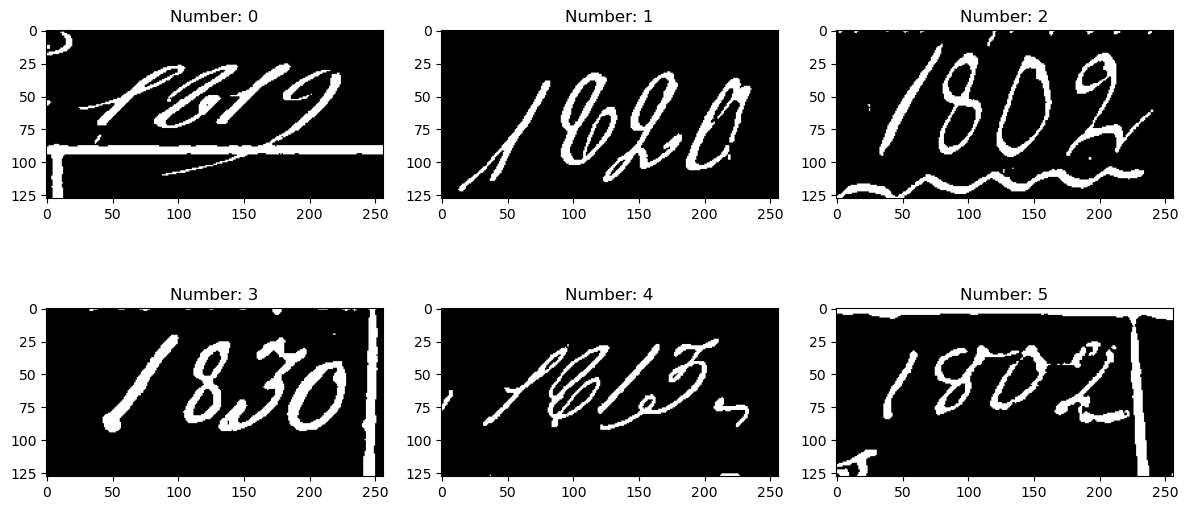

In [83]:
sample_visualizer(random_threshold_str_samples, fsize = (12, 6), dim = (2, 3), title = 'Number', cmap = 'gray')

### 6.5 Image morphology <a class="anchor" id="section6_5"></a>

The area opening alorithm is similar to morphological opening algorithm, but insted of fixed structural element it uses deformable one with surface = area_treshold. This alorithm performs erosion and then dilation and removes small artifact and in some cases it can split connected digits. Note that this algorithm can be replaced with the binary one which needs choosing good structural element. Binary algorithm is also faster [8], [9].

In [84]:
def morph_open(img):
    morph_image = []
    for image in img:
        im = area_opening(image)
        morph_image.append(im)
    morph_image_arr = np.asarray(morph_image)
    return morph_image_arr

In [85]:
morph_str_images = morph_open(threshold_str_images)

In [86]:
morph_str_images.shape

(12000, 128, 256)

In [87]:
random_morph_str_samples = random_sample_picker(morph_str_images, elem_range = (0, 12000), samples = 6)

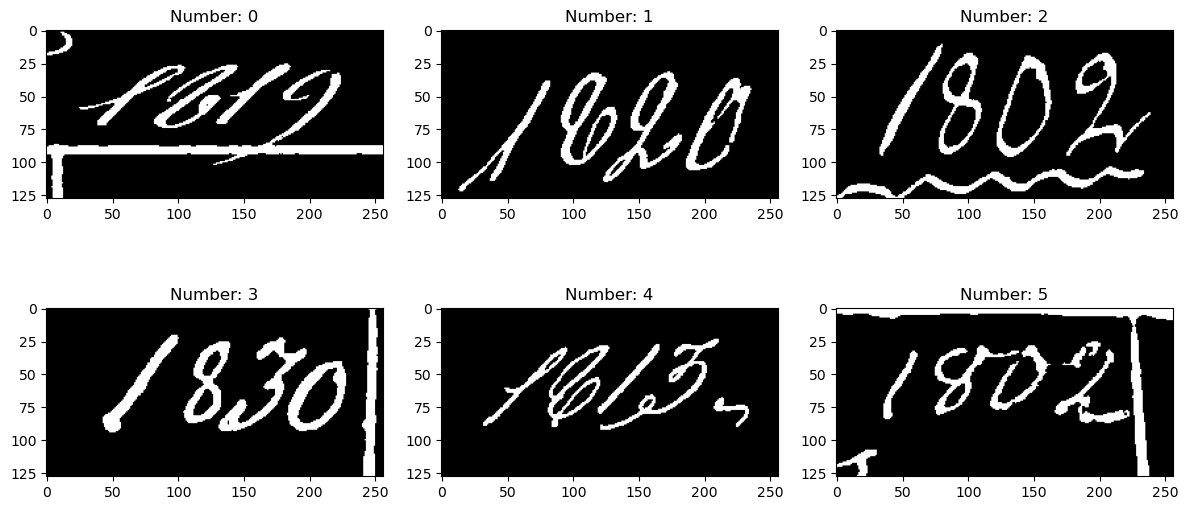

In [88]:
sample_visualizer(random_morph_str_samples, fsize = (12, 6), dim = (2, 3), title = 'Number', cmap = 'gray')

### 6.6 Image segmentation <a class="anchor" id="section6_6"></a>

Here for digit segmentation it is used connected components method with connectivity type 1. If the digits are not scattered or connected to each other, they should be properly segmented [10].

#### 6.6.1 Image segments visualization <a class="anchor" id="sub_section6_6_1"></a>

In [89]:
def image_label_visualizer(img, dim = (2, 3), fsize = (12, 6), title = 'Number'):
    rows, columns = dim
    im_index = 0
    fig, axes = plt.subplots(rows, columns, figsize = fsize)
    for row in range(0, rows):
        for col in range(0, columns):
            sub_image = img[im_index]
            
            image_area = (sub_image.shape[0] * sub_image.shape[1])
            segments = []

            img_label = label(sub_image, connectivity=1) # label objects
            regions = regionprops(img_label) # get region properties

            # create bounding box
            for props in regions:
            #    print('A', props.bbox_area / image_area)
                if (props.bbox_area / image_area) < 0.25 and (props.bbox_area / image_area) > 0.03: # Need to check the lower area limit
                    minr, minc, maxr, maxc = props.bbox
            #        print('R', (maxr - minr) / (maxc - minc))
                    if (maxr - minr) / (maxc - minc) < 2.5 and (maxr - minr) / (maxc - minc) >= 0.5:
                        bx = (minc, maxc, maxc, minc, minc)
                        by = (minr, minr, maxr, maxr, minr)
                        axes[row, col].plot(bx, by, "-r", linewidth=0.5)
                        segments.append(props.bbox)            
            #            print(props.bbox_area / image_area)
            #            print('minr', minr, 'minc', minc, 'maxr', maxr, 'maxc', maxc)
#                        print(props.bbox)

            axes[row, col].imshow(img_label)
            axes[row, col].set_title('{}: {}\nDetected Digits: {}'.format(title, im_index, len(segments)))
            im_index += 1
            
    plt.tight_layout()
    plt.show()

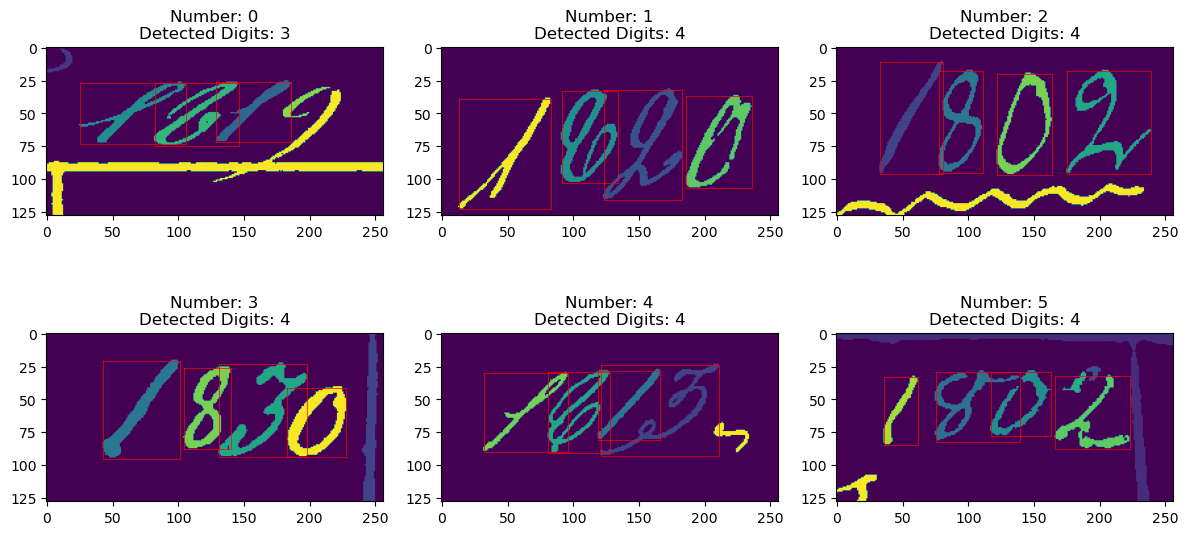

In [90]:
image_label_visualizer(random_morph_str_samples)

This function is used for the segmentation over the dataset. It also sorts all segments from left to right. Because during segmentation, the order of elements is random.

#### 6.6.2 Processing and ordering of the segments <a class="anchor" id="sub_section6_6_2"></a>

In [91]:
def segmented_images(img, img_orig):
    images = []
#    left2right_boxes = []
    left2right_boxes = {}

    items = zip(img, img_orig)
    for index, (img_in, img_orign) in enumerate(items):
#        print(index)
        segments = []
        image_area = (img_in.shape[0] * img_in.shape[1])
        img_label = label(img_in) # label objects
        regions = regionprops(img_label) # get region properties

        # create bounding box
        for props in regions:
            if (props.bbox_area / image_area) < 0.25 and (props.bbox_area / image_area) > 0.03:
                minr, minc, maxr, maxc = props.bbox
                if (maxr - minr) / (maxc - minc) < 2.5 and (maxr - minr) / (maxc - minc) >= 0.5:
                    segments.append(props.bbox)
                    
        columns = []
        l2r_boxes = []
        for first_column in segments:
            columns.append(first_column[1])
        columns.sort()

        for col in columns:
            for box in segments:
                if col in box[1:2]:
#                    print(box[1:2])
                    l2r_boxes.append(box)
#                    boxes.remove(box)            
                    
        images.append(img_orign)
        left2right_boxes[index] = l2r_boxes
#        left2right_boxes.append(l2r_boxes)
#    left2right_boxes_arr = np.asarray(left2right_boxes)
    images_arr = np.asarray(images)
    return images_arr, left2right_boxes

### 6.7 Experimenting with the assumption that the 10k single digit data set is a subset of the 12k string image dataset <a class="anchor" id="section6_7"></a>

#### 6.7.1 Creating new SVM classifier without PCA <a class="anchor" id="sub_section6_7_1"></a>

Perform train-test-split procedure without PCA. Original HOG features and labels from the 10k sigle digit dataset will be used.

In [92]:
single_image_train_hog, single_image_test_hog, single_labels_train_hog, single_labels_test_hog = \
train_test_split(hog_image_features, single_image_labels, test_size = 0.15, stratify = single_image_labels, random_state = 8)

In [93]:
single_image_train_hog.shape, single_image_test_hog.shape, single_labels_train_hog.shape, single_labels_test_hog.shape

((8500, 576), (1500, 576), (8500,), (1500,))

Initialization of the parameter grid. The parameters in the parameter grid are the same as these from the model which uses PCA.

In [94]:
param_grid_hog = {
    'penalty': ['l2'],
    'loss': ['hinge', 'squared_hinge'],
    'tol': [1e-3, 1e-4, 1e-5],
    'C': [ 0.01, 0.1, 1],
    'max_iter': [10000],
    'random_state': [8]
}

In [95]:
single_digit_classifier_hog = GridSearchCV(LinearSVC(), param_grid_lin, cv = 5)

In [96]:
single_digit_classifier_hog.fit(single_image_train_hog, single_labels_train_hog)

GridSearchCV(cv=5, estimator=LinearSVC(),
             param_grid={'C': [0.01, 0.1, 1],
                         'loss': ['hinge', 'squared_hinge'],
                         'max_iter': [10000], 'penalty': ['l2'],
                         'random_state': [8], 'tol': [0.001, 0.0001, 1e-05]})

The hyperparameters are the same as these from the model which uses PCA.

In [97]:
print(single_digit_classifier_hog.best_params_)

{'C': 0.1, 'loss': 'squared_hinge', 'max_iter': 10000, 'penalty': 'l2', 'random_state': 8, 'tol': 0.001}


In [98]:
single_digit_predicted_hog = single_digit_classifier_hog.best_estimator_.predict(single_image_test_hog)

Classification report for classifier GridSearchCV(cv=5, estimator=LinearSVC(),
             param_grid={'C': [0.01, 0.1, 1],
                         'loss': ['hinge', 'squared_hinge'],
                         'max_iter': [10000], 'penalty': ['l2'],
                         'random_state': [8], 'tol': [0.001, 0.0001, 1e-05]}):
              precision    recall  f1-score   support

         0.0       0.92      0.93      0.92       150
         1.0       0.88      0.87      0.88       150
         2.0       0.91      0.91      0.91       150
         3.0       0.85      0.86      0.86       150
         4.0       0.90      0.89      0.90       150
         5.0       0.91      0.95      0.93       150
         6.0       0.91      0.93      0.92       150
         7.0       0.91      0.91      0.91       150
         8.0       0.91      0.90      0.90       150
         9.0       0.89      0.84      0.87       150

    accuracy                           0.90      1500
   macro avg       0

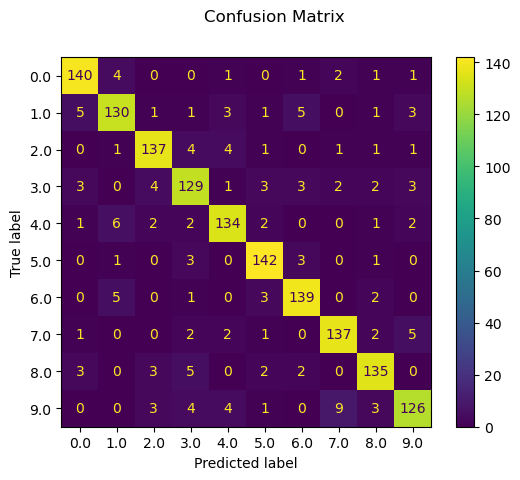

In [99]:
metrics(single_digit_classifier_hog ,single_labels_test_hog, single_digit_predicted_hog)

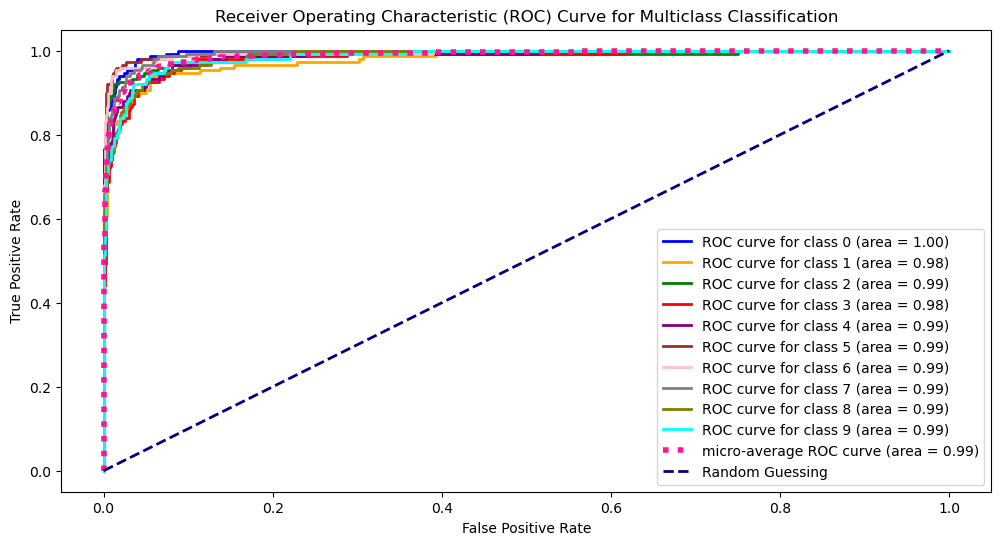

In [100]:
multiclass_roc_plot(hog_image_features, single_image_labels, np.unique(single_image_labels), single_digit_classifier_hog.best_estimator_, test_size = 0.15)

The model performance is exactly the same as the previous model which uses PCA.

### 6.8 Storing the best estimator <a class="anchor" id="section6_8"></a>

In [101]:
joblib.dump(single_digit_classifier_hog.best_estimator_, 'single_digit_hog_model')

['single_digit_hog_model']

### 6.9 Cropping and classifying each segmented image <a class="anchor" id="section6_9"></a>

Loading 6 random string images. Each segment from each image will be classified. And then it can be visually checked.

In [102]:
random_original_str_samples = random_sample_picker(resized_str_image_collection, elem_range = (0, 12000), samples = 6)

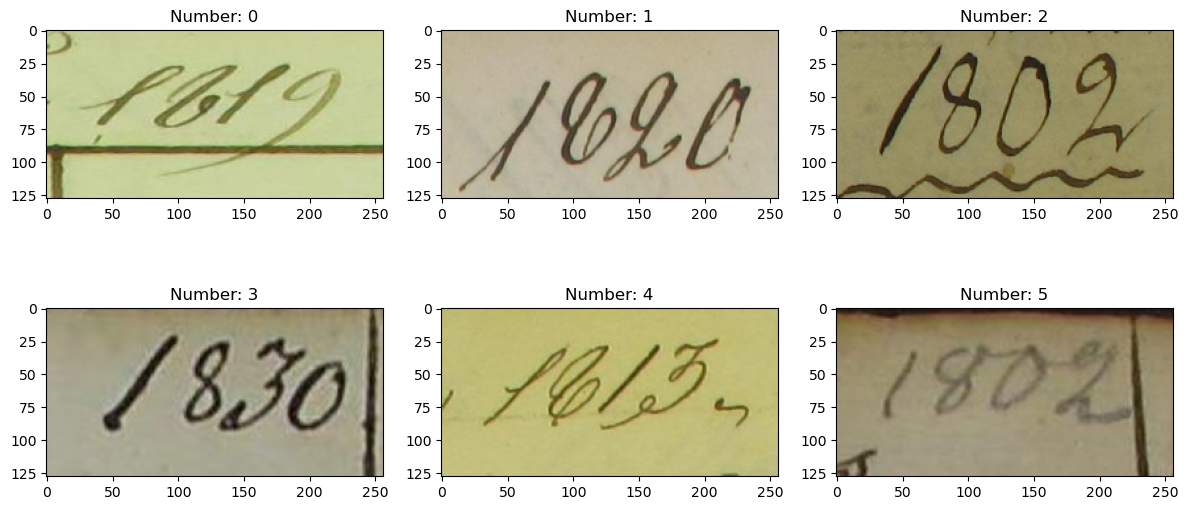

In [103]:
sample_visualizer(random_original_str_samples, fsize = (12, 6), dim = (2, 3), title = 'Number')

In [104]:
random_str_images, random_str_image_segments = segmented_images(random_morph_str_samples, random_original_str_samples)

In [105]:
random_str_images.shape

(6, 128, 256, 3)

This procedure takes the original resolution normalised images and crops each detected segment in correspondance to the bounding box. Then each cropped piece will be normalised to 32x32pix resolution.

In [106]:
def image_crop_res(img, box, res=(32, 32)):
    image_segments = {}
    items = zip(img, box)
    for index in range(0, img.shape[0]):
        cropped_images = []
        for box_crop in box.get(index):
            if not box_crop:
                print("dict is empty")
                cropped_images.append(9999)
            else:
                row_first, col_first, row_last, col_last = box_crop
                resized_image = resize(img[index][row_first:row_last, col_first:col_last], res)
                cropped_images.append(resized_image)
        image_segments[index] = cropped_images
    return image_segments

In [107]:
cropped_random_str_images = image_crop_res(random_str_images, random_str_image_segments)

This procedure takes each cropped segment and performs classification on it using the optimised SVM which uses HOG features.

In [108]:
def segment_classification(dict_in, classifier):
#    pca_segments = PCA()
    segmnets_predictions = {}
    for index in range(0, len(dict_in)):
        segments = dict_in.get(index)
#        print(len(segments))
        if not segments:
            segmnets_predictions[index] = [9999]
        else:
            hog_segments = hog_descriptor(segments)
            predictions = classifier.predict(hog_segments)
            segmnets_predictions[index] = predictions.astype('int32')
    return segmnets_predictions


In [109]:
h_seg = segment_classification(cropped_random_str_images, single_digit_classifier_hog)

In [110]:
h_seg

{0: array([1, 6, 1]),
 1: array([1, 8, 2, 0]),
 2: array([1, 8, 0, 2]),
 3: array([1, 8, 3, 0]),
 4: array([1, 8, 1, 0]),
 5: array([6, 5, 0, 2])}

These are the results of the six randomly selected numbers above.
- For the first number it is only digits 1 that are properly recognized. Number 8 is wrong recognized as 6. Number 9 is not recognized at all.
- The second number is fully recognized.
- The third number is fully recognized.
- The forth number is also fully recognized.
- The fifth number is not properly recognized. Both digit 1 are properly recognized. The numbers 8 and 3 are recognized as 0s in this case.
- The sixth number is almost fully recognized. It can be seen that the last 3 digit are sligtly connected. They have 'tails' and that's why the number 8 is recognized as number 5.

Segmentation and classification of each string image.

In [111]:
original_str_images, str_image_segments = segmented_images(morph_str_images, resized_str_image_collection)

In [112]:
original_str_images.shape

(12000, 128, 256, 3)

In [113]:
len(str_image_segments)

12000

In [114]:
cropped_str_images = image_crop_res(original_str_images, str_image_segments)

In [115]:
classified_str_images = segment_classification(cropped_str_images, single_digit_classifier_hog)

In [116]:
len(classified_str_images)

12000

### 6.10 Loading digit labels from the 12k string image dataset <a class="anchor" id="section6_10"></a>

Loading and visualization of the labes for the 12k string image dataset.

In [117]:
str_image_labels = pd.read_csv("C:/Users/adm/Desktop/DIDA/archive/DIDA_12000_String_Digit_Labels.csv", header = None)

In [118]:
str_image_labels.head()

,0,1
0,1,1836
1,2,1836
2,3,1840
3,4,1840
4,5,1823


Renaming the label column. Then each label (number) is splitted into digits, because later 1:1 check will be performed on each one- each recognized digit vs. the label.

In [119]:
str_image_labels = str_image_labels.rename(columns={1: "labels"})

In [120]:
str_image_labels.head()

,0,labels
0,1,1836
1,2,1836
2,3,1840
3,4,1840
4,5,1823


In [121]:
str_image_labels['lbl'] = str_image_labels['labels'].astype('str')

In [122]:
str_image_labels['d1'] = str_image_labels['lbl'].str[0:1]
str_image_labels['d2'] = str_image_labels['lbl'].str[1:2]
str_image_labels['d3'] = str_image_labels['lbl'].str[2:3]
str_image_labels['d4'] = str_image_labels['lbl'].str[3:4]

In [123]:
str_image_labels

,0,labels,lbl,d1,d2,d3,d4
0,1,1836,1836,1,8,3,6
1,2,1836,1836,1,8,3,6
2,3,1840,1840,1,8,4,0
3,4,1840,1840,1,8,4,0
4,5,1823,1823,1,8,2,3
...,...,...,...,...,...,...,...
11995,11996,1808,1808,1,8,0,8
11996,11997,1809,1809,1,8,0,9
11997,11998,1840,1840,1,8,4,0
11998,11999,1840,1840,1,8,4,0


In [124]:
str_image_labels.head(10)

,0,labels,lbl,d1,d2,d3,d4
0,1,1836,1836,1,8,3,6
1,2,1836,1836,1,8,3,6
2,3,1840,1840,1,8,4,0
3,4,1840,1840,1,8,4,0
4,5,1823,1823,1,8,2,3
5,6,1823,1823,1,8,2,3
6,7,59,59,5,9,,
7,8,61,61,6,1,,
8,9,62,62,6,2,,
9,10,63,63,6,3,,


Creating index column and drop-out the useless ones.

In [125]:
str_image_labels['index'] = str_image_labels.index

In [126]:
str_image_labels = str_image_labels.drop(columns = [0, 'labels', 'lbl'])

In [127]:
str_image_labels.head()

,d1,d2,d3,d4,index
0,1,8,3,6,0
1,1,8,3,6,1
2,1,8,4,0,2
3,1,8,4,0,3
4,1,8,2,3,4


Converting the splitted numbers (digits) from string data type to int32 data type. Otherwise they cannot be compared. Most of the numbers are with four digits, but some of them has less. These missing values are filled with the number '9999'.

In [128]:
str_image_labels['d1'] = pd.to_numeric(str_image_labels['d1'], errors='coerce').fillna(9999).astype(np.int32)
str_image_labels['d2'] = pd.to_numeric(str_image_labels['d2'], errors='coerce').fillna(9999).astype(np.int32)
str_image_labels['d3'] = pd.to_numeric(str_image_labels['d3'], errors='coerce').fillna(9999).astype(np.int32)
str_image_labels['d4'] = pd.to_numeric(str_image_labels['d4'], errors='coerce').fillna(9999).astype(np.int32)

In [129]:
str_image_labels.head(10)

,d1,d2,d3,d4,index
0,1,8,3,6,0
1,1,8,3,6,1
2,1,8,4,0,2
3,1,8,4,0,3
4,1,8,2,3,4
5,1,8,2,3,5
6,5,9,9999,9999,6
7,6,1,9999,9999,7
8,6,2,9999,9999,8
9,6,3,9999,9999,9


Converting the dataframe to python dictionary. It will be easy for comparison, because the prediction function also returns dictionary.

In [130]:
str_image_labels_dict = str_image_labels.set_index('index').T.to_dict('list')

In [131]:
def result_comparison(labels, predictions):

    if len(labels) == len(predictions):
        final_comparison_result = []
        recognized_digits = [0, 0, 0, 0, 0]
        for i in range(0, len(labels)):
            fully_recognized_images = 0
            for x in range(0, len(predictions[i])):

                if x <= 3:

                    if labels[i][x] == predictions[i][x]:
                        if labels[i][x] != 9999:
            #                print(True)
                            recognized_digits[x] += 1
                            fully_recognized_images += 1
                            if fully_recognized_images == len(labels[i]):
                                recognized_digits[4] += 1
                        else:
                            pass
                else:
                    pass
        a, b, c, d, e = recognized_digits        
        print('Properly recognized digits: \nFirst position {}, \
                \nSecond position {}, \
                \nThird position {}, \
                \nFourth position {}, \
                \nFully recognized numbers {}'.format(a, b, c, d, e))
#        return recognized_digits

In [132]:
result_comparison(str_image_labels_dict, classified_str_images)

Properly recognized digits: 
First position 9461,                 
Second position 6019,                 
Third position 5894,                 
Fourth position 4658,                 
Fully recognized numbers 2512


This direct comparison is a bit harsh, but it can give some basic idea of the result. Shoud be taken into account that some images has less than 4 numbers and also it cannot be guaranteed that the first segmented element will be truly the first digit from the image string.

## 7 Discussion <a class="anchor" id="chapter7"></a>

This notebook covers some basic concepts of image processing and image classification. Standard Machine Learning algorithms were used for image recognition purpose. The techniques and algorithms used alone are not sufficient to recognize handwritten numbers. This work is more of a starting point for that.

1. The following changes can be made to improve results:
    - Optimization of the segmentation algorithm. Improvement of boundaries related to the areas and shapes of the desired objects for segmentation. Slight increase in boundary box dimensions. This can help with better digit recognition. Because most of the single digit images are not cut tightly around the number. 
    - Searching for better segmentation algorithms.
    - Classifier can be trained with more examples. A dataset with 70k or even 250k samples can be used.
    - Using better methods to evaluate the segmentation results as well as compare them with the provided labels.
    - Use of SGD classifier to be able to use partial training for large datasets.

2. To improve the performance of the code, some of the algorithms can be revised. Changing their hyper parameters or replacing them with similar faster ones.
    - An example of this is the morphological operation that is currently in use. For greater speed, a binary one can be used.

3. To optimize system resources, instead of each procedure processing the entire dataset and saving it to the system memory after each step, each image one by one goes through all the steps, thus saving only the final result. If analysis of problematic images is required, each final result can be saved with the corresponding image label. Then all procedures can be performed one by one on these images.

4. For workflow optimization, data processing pipelines should be completed.

5. It is important to mention that the labels provided with the 12k string digit dataset have gaps. Some four-digit images have only 3 digits as a label.

In conclusion, it can be noted that for similar or more complex image processing tasks it is good to use neural networks (NN). And in the case of image processing- preferably convolutional neural networks (CNN). Vision transformers (ViT) can be used as well, which are also a neural network. These algorithms have a huge capacity to detect and understand important details in images, and also to segment and classify them.

## 8 Literature <a class="anchor" id="chapter8"></a>

* [1] Huseyin Kusetogullari, Amir Yavariabdi, Johan Hall, Niklas Lavesson, "DIGITNET: A Deep Handwritten Digit Detection and Recognition Method Using a New Historical Handwritten Digit Dataset", Big Data Research, 2020, DOI: 10.1016/j.bdr.2020.100182.
* [2] Huseyin Kusetogullari, Amir Yavariabdi, Johan Hall, Niklas Lavesson, DIDA: The largest historical handwritten digit dataset with 250k digits, June 2021. Accessed on: June 13, 2021. Available: https://github.com/didadataset/DIDA/.
* [3] https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_hog.html
* [4] https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients
* [5] https://scikit-image.org/docs/0.20.x/auto_examples/filters/plot_unsharp_mask.html
* [6] https://en.wikipedia.org/wiki/Unsharp_masking
* [7] https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_niblack_sauvola.html
* [8] https://scikit-image.org/skimage-tutorials/lectures/3_morphological_operations.html
* [9] https://en.wikipedia.org/wiki/Mathematical_morphology
* [10] https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.label

Other useful sources:
* Youtube: First Principles of Computer Vision
* Youtube: Machine Learning Studio